In [1]:
# particle filtering (PF) application to SEIR epidemiology models
# Reference article: Safarishahrbijari et al. (2017):Predictive accuracy of particle filtering in dynamic models supporting outbreak projections

In [9]:
# required libraries
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
from scipy.stats import nbinom
from scipy.special import logit, expit
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from numpy.random import uniform
import random

In [25]:
# initial parameters
random.seed(123)
beta = 0.06
tau = 3
mu = 7
va = 14
a = 0.05
b = 0.9
N = 1214403 # total population
gamma = 0.5 # standard deviation for the contact rate random walk
eta = 1 # standard deviation for the fraction of infections reported- logit function
param = (beta,tau,mu,va,a,b,N)
n = 366 # number of time points 
r = 10 # dispersion parameter
# time points
t = np.linspace(0,365,n)
epsilon = 1e-36
# observed daily cases of infection- read from synthetic data
observed_cases = pd.read_csv('./data_daily.csv')
# sample size threshold
nparticles = 10000 # number of particles
szt = 1E10#round(0.75*nparticles)
# days of data used for prediction using PF
pf_day = 200
training = observed_cases[observed_cases['day']<=pf_day]
testing = observed_cases[observed_cases['day']>pf_day]

In [26]:
# SEIR-V function
def SEIRV(z,t,c,beta,tau,mu,va,a,b,N):
    S = z[0] # susceptible
    E = z[1] # exposed
    I = z[2] # infected
    R = z[3] # recovered
    V = z[4] # vaccinated
    # c: contact rate per day
    # beta: probability of infection given exposure
    # tau: mean number of days in latent state
    # mu: mean number of days to recovery
    # va: mean number of days for immunity to develop
    # a: per capita vaccination rate
    # b: vaccine effectiveness
    dSdt = -math.exp(c)*beta*I*S/N - a*b*S
    dEdt = math.exp(c)*beta*I*S/N + math.exp(c)*beta*I*V/N - E/tau
    dIdt = E/tau - I/mu
    dRdt = I/mu + V/va
    dVdt = a*b*S - V/va - math.exp(c)*beta*I*V/N
    dZdt = [dSdt,dEdt,dIdt,dRdt,dVdt]
    return dZdt


In [27]:
# function to create particles
def create_particles(NP,NS):
    # NP: number of particles
    # NS: population size
    particles = np.empty((NP, 7))
    # S0: truncated normal with mu = 900000, sd = 150000, min = 0, max = N-I0
    s_mu = 900000
    s_sd = 150000
    # I0: constant value of 7 for all particles
    I0 = 7
    # E0: 0 for all particles
    E0 = 0
    # R0: N-S0-E0-I0-V0
    # V0: 0 for all particles
    V0 = 0
    # C0: log-transformed value follows a uniform between 1 and 300
    c_min = 1
    c_max = 300
    # f: fraction of reported infections- follows a logit function
    f_min = 0
    f_max = 1
    particles[:, 0] = list(np.around(np.clip(np.random.normal(s_mu,s_sd, size = NP),0,N-I0))) #S
    particles[:, 1] = [E0]*NP #E
    particles[:, 2] = [I0]*NP #I
    particles[:, 4] = [V0]*NP #V
    particles[:, 3] = [NS]*NP - (particles[:, 0]+particles[:, 1]+particles[:, 2]+particles[:, 4]) #R
    particles[:,5] = list(np.log(np.random.uniform(c_min, c_max,size  = NP)))
    particles[:,6] = list(logit(np.random.uniform(f_min, f_max,size  = NP)))
    return particles

In [28]:
particles = pd.DataFrame(create_particles(nparticles,N))
# initialize particle normalized weights
npw = np.ones(nparticles)/nparticles

In [29]:
# store solutions
S = pd.DataFrame(np.zeros((nparticles,len(t))))
E = pd.DataFrame(np.zeros((nparticles,len(t))))
I = pd.DataFrame(np.zeros((nparticles,len(t))))
R = pd.DataFrame(np.zeros((nparticles,len(t))))
V = pd.DataFrame(np.zeros((nparticles,len(t))))
C = pd.DataFrame(np.zeros((nparticles,len(t))))
f = pd.DataFrame(np.zeros((nparticles,len(t))))
RI = pd.DataFrame(np.zeros((nparticles,len(t))))
Z0 = pd.DataFrame(np.zeros((nparticles,5)))
weights = pd.DataFrame(np.zeros((nparticles,len(training) + 1)))
weights.iloc[:,0] = npw

In [30]:
# particle filtering flag
pf_flag = True
# solve and plot ODE for all particles
for j in range(nparticles):
    Z0.iloc[j,:] = particles.iloc[j,:-2]
    S.iloc[j,0] = Z0.iloc[j,0]
    E.iloc[j,0] = Z0.iloc[j,1]
    I.iloc[j,0] = Z0.iloc[j,2]
    R.iloc[j,0] = Z0.iloc[j,3]
    V.iloc[j,0] = Z0.iloc[j,4]
    C.iloc[j,0] = particles.iloc[j,-2]
    f.iloc[j,0] = particles.iloc[j,-1]
    RI.iloc[j,0] = 0
k = 1
for i in range(1,n):
    # span for next time step
    # loop over particles and solve the ode
    tspan = [t[i-1],t[i]]
    for j in range(nparticles):
        Z = odeint(SEIRV,Z0.iloc[j,:],tspan,args = tuple([C.iloc[j,i-1]] +list(param)))
        # store solution for plotting; note: output represents two values of current (Z0) and next timestep (Z1) within tspan
        S.iloc[j,i] = np.clip(Z[1][0],0,N)
        E.iloc[j,i] = np.clip(Z[1][1],0,N)
        I.iloc[j,i] = np.clip(Z[1][2],0,N)
        R.iloc[j,i] = np.clip(Z[1][3],0,N)
        V.iloc[j,i] = np.clip(Z[1][4],0,N)
        C.iloc[j,i] = C.iloc[j,i-1] + (t[i] - t[i-1])*np.random.normal(0,gamma**2,1)[0]
        f.iloc[j,i] = f.iloc[j,i-1] + (t[i] - t[i-1])*np.random.normal(0,eta**2,1)[0]
        #RI.iloc[j,i] = I.iloc[j,i] * expit(f.iloc[j,i])
        RI.iloc[j,i] = (E.iloc[j,i-1]/tau)* expit(f.iloc[j,i])
        # next initial condition
        Z0.iloc[j,:] = np.clip(Z[1],0,N)
    if pf_flag:
        if i in training.day.values:
            # observed data is available for the selected day
            yi = list(training[training['day'] == i].cases)[0]
            pw = np.empty(nparticles)
            for j in range(nparticles):
                p = round(RI.iloc[j,i])/(round(RI.iloc[j,i])+r)
                # calculate the likelihood using negative binomial
                pw[j] = npw[j]*nbinom.pmf(r,max(yi,epsilon),max(p,epsilon))
            # normalize the weights
            npw = pw/sum(pw)
            # calculate effective sample size
            effective_sz = 1/(sum([a**2 for a in pw]) + epsilon)
            weights.iloc[:,k] = npw
            k = k + 1
            if effective_sz <szt:  
                print("simulation day: ",i,"- Resampling is done")
                # conduct importance sampling using the normalized weights
                selected_index = random.choices([i for i in range(len(pw))],npw,k=len(pw))
                # reset the particle weights to 1/NP once resampling is done
                npw = np.ones(nparticles)/nparticles
                S = S.iloc[selected_index,:].reset_index(drop=True)
                E = E.iloc[selected_index,:].reset_index(drop=True)
                I = I.iloc[selected_index,:].reset_index(drop=True)
                R = R.iloc[selected_index,:].reset_index(drop=True)
                V = V.iloc[selected_index,:].reset_index(drop=True)
                C = C.iloc[selected_index,:].reset_index(drop=True)
                f = f.iloc[selected_index,:].reset_index(drop=True)
                RI = RI.iloc[selected_index,:].reset_index(drop=True)
                Z0 = Z0.iloc[selected_index,:].reset_index(drop=True)
             

simulation day:  3 - Resampling is done
simulation day:  4 - Resampling is done
simulation day:  5 - Resampling is done
simulation day:  6 - Resampling is done
simulation day:  7 - Resampling is done
simulation day:  8 - Resampling is done
simulation day:  9 - Resampling is done
simulation day:  10 - Resampling is done
simulation day:  11 - Resampling is done
simulation day:  12 - Resampling is done
simulation day:  13 - Resampling is done
simulation day:  14 - Resampling is done
simulation day:  15 - Resampling is done
simulation day:  16 - Resampling is done
simulation day:  17 - Resampling is done
simulation day:  18 - Resampling is done
simulation day:  19 - Resampling is done
simulation day:  20 - Resampling is done
simulation day:  21 - Resampling is done
simulation day:  22 - Resampling is done
simulation day:  23 - Resampling is done
simulation day:  24 - Resampling is done
simulation day:  25 - Resampling is done
simulation day:  26 - Resampling is done
simulation day:  27 - R

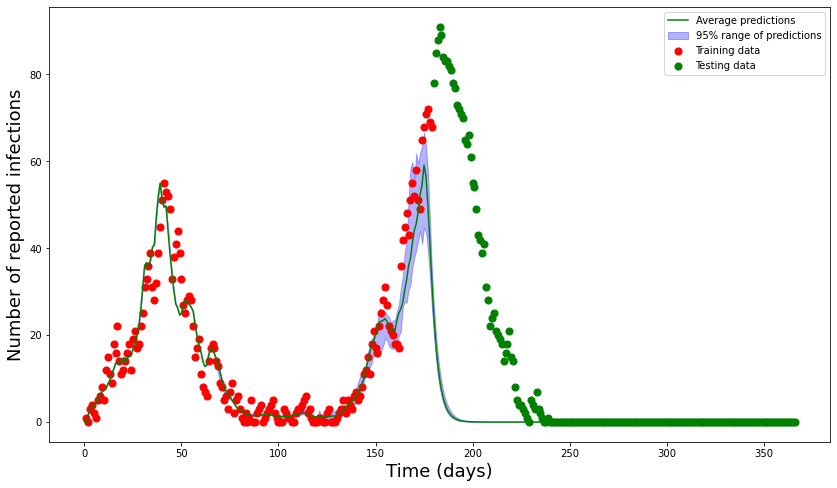

In [23]:
# observed values vs 95% probability range of predictions
fig = plt.figure(figsize = (14,8))
RI_mean = RI.mean()
RI_sd = RI.std()
RI_lb = RI.quantile(0.025)
RI_ub = RI.quantile(0.975)
plt.fill_between(t, RI_lb, RI_ub, color='b', alpha=.3, label = "95% range of predictions")
plt.scatter(training['day'],training['cases'],color = 'r',s=50,label = "Training data")
plt.scatter(testing['day'],testing['cases'],color = 'g',s=50,label = "Testing data")
plt.plot(t,RI_mean,'g',label = "Average predictions")
plt.xlabel('Time (days)', fontsize=18)
plt.ylabel('Number of reported infections', fontsize=18)
plt.legend(loc="upper right")


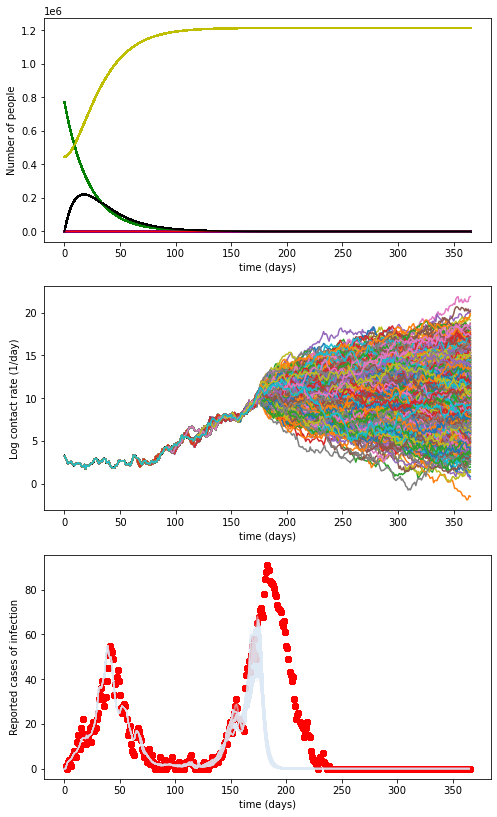

In [24]:
fig,axs = plt.subplots(nrows = 3, ncols =1,figsize = (8,14))
# plotting the results  
for j in range(nparticles):
    axs[0].plot(t,S.iloc[j,:],'g')
    axs[0].plot(t,E.iloc[j,:],'b')
    axs[0].plot(t,I.iloc[j,:],'r')
    axs[0].plot(t,R.iloc[j,:],'y')
    axs[0].plot(t,V.iloc[j,:],'black')
    axs[1].plot(t,C.iloc[j,:])
    axs[2].scatter(observed_cases['day'],observed_cases['cases'],color = 'r',s=25)
    axs[2].plot(t,RI.iloc[j,:],'#dde9f4',alpha = 0.05)
axs[0].set(xlabel="time (days)", ylabel="Number of people")
axs[1].set(xlabel="time (days)", ylabel="Log contact rate (1/day)")
axs[2].set(xlabel="time (days)", ylabel="Reported cases of infection")
plt.show()